In [1]:
import os
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from sklearn.base import clone
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Linear regression

## Load data

In [2]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

566

In [3]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'soil region', 'population',
       'groundwater depth', 'elevation', 'lon', 'lat', 'precipitation',
       'temperature', 'n deposition', 'mainsoilclassification_1',
       'organicmattercontent_1', 'density_1', 'acidity_1', 'landuse code'],
      dtype='object')

In [4]:
# df = df[df["soil region"] != "veen"]
# len(df)

## Sort by date

In [5]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [6]:
# df = df.drop(columns=['soil region', 'landuse code'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

313

## Add month and year as a feature

In [7]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [8]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

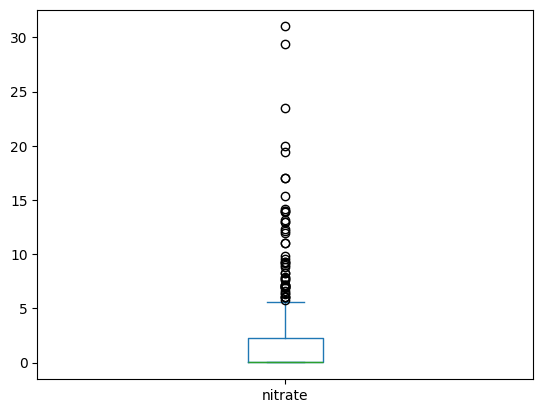

In [9]:
df[["nitrate"]].plot(kind = "box")

In [10]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
# outliers

Outliers found: 48


In [11]:
# top_nitrate_outliers = list(df["nitrate"].sort_values()[-3:].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Test / train split

In [12]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 260
Test: 34


In [13]:
# n = len(df)
# train_size = int(n * 0.8)

# train_df = df.iloc[:train_size]
# test_df = df.iloc[train_size:]

# print(f"Train: {len(train_df)}")
# print(f"Test: {len(test_df)}")


In [14]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [15]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [16]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['soil region', 'mainsoilclassification_1', 'landuse code']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['soil region', 'population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'landuse code']


In [17]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [18]:
lr_model = Ridge(alpha=1.0)

In [19]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("lr", lr_model)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [20]:
# Alpha grid (logarithmic scale)
alphas = np.logspace(-4, 4, 50)

# Time series split
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with time series CV
param_grid = {
    "regressor__lr__alpha": alphas
}

grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # or "neg_root_mean_squared_error"
    cv=tscv,
    n_jobs=-1,
    verbose=1
)


## Train model

In [21]:
# Fit
grid.fit(X_train, y_train)

# Best model and alpha
best_model = grid.best_estimator_
print("Best alpha:", grid.best_params_["regressor__lr__alpha"])
print("Best CV MAE:", -grid.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best alpha: 0.5689866029018293
Best CV MAE: 1.6296357471459195


## Learning curve

In [22]:
train_sizes = np.linspace(0.3, 1.0, 10)
train_sizes

array([0.3       , 0.37777778, 0.45555556, 0.53333333, 0.61111111,
       0.68888889, 0.76666667, 0.84444444, 0.92222222, 1.        ])

In [23]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=7)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

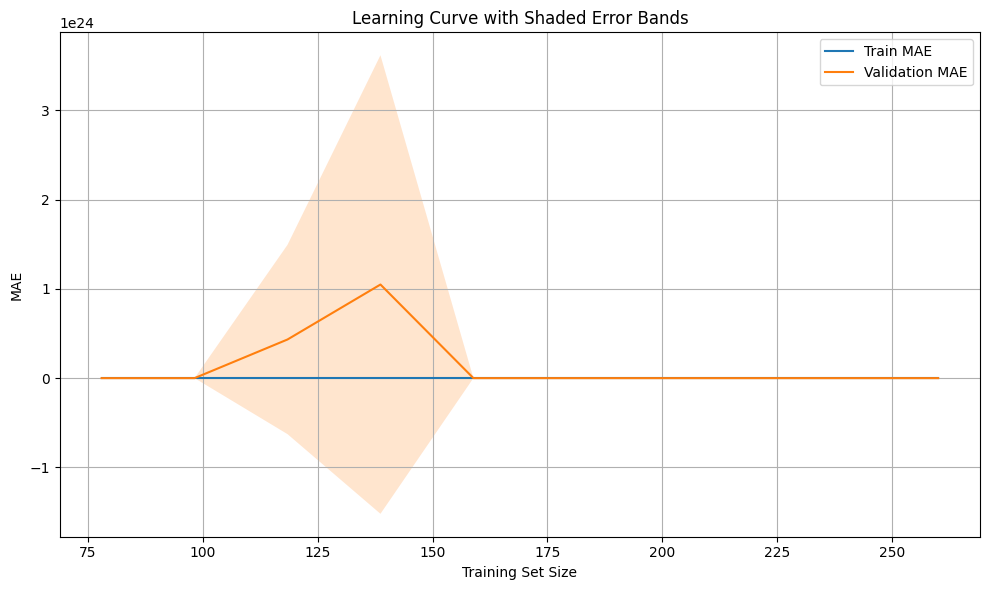

In [24]:
# X-axis
train_sizes_abs = train_sizes * len(X_train)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve with Shaded Error Bands")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

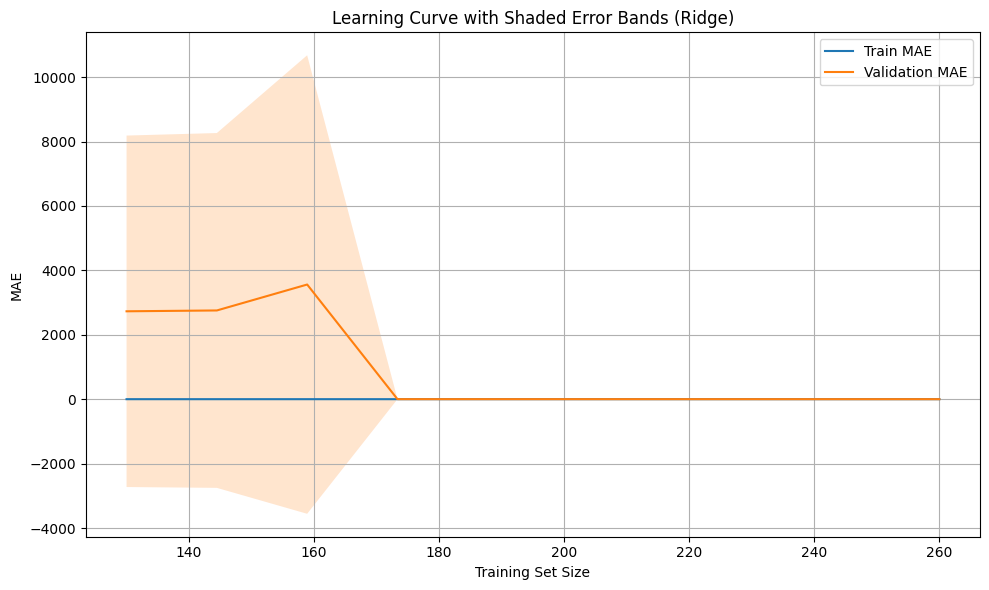

In [25]:
from sklearn.linear_model import Ridge

# Use optimal alpha from grid search
best_alpha = grid.best_params_["regressor__lr__alpha"]

ridge = Ridge(alpha=best_alpha)
model = Pipeline([
    ("prep", preprocessor),
    ("ridge", ridge)
])

train_errors = []
val_errors = []
train_stds = []
val_stds = []

train_sizes = np.linspace(0.5, 1.0, 10)
n = len(X_train)

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=5)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        # Manual log-transform
        y_tr_log = np.log1p(y_tr)
        y_val_log = np.log1p(y_val)

        model.fit(X_tr, y_tr_log)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        # Clip to avoid np.expm1 overflow
        y_tr_pred = np.clip(y_tr_pred, -10, 10)
        y_val_pred = np.clip(y_val_pred, -10, 10)

        # Inverse transform
        y_tr_pred_orig = np.expm1(y_tr_pred)
        y_val_pred_orig = np.expm1(y_val_pred)
        y_tr_orig = np.expm1(y_tr_log)
        y_val_orig = np.expm1(y_val_log)

        fold_train_scores.append(mean_absolute_error(y_tr_orig, y_tr_pred_orig))
        fold_val_scores.append(mean_absolute_error(y_val_orig, y_val_pred_orig))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

# Plotting
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs,
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs,
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve with Shaded Error Bands (Ridge)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model

In [26]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['soil '
                                                                                        'region',
                                                                                        'mainsoilclassification_1',
                                                                                        'landuse '
                                                                                        'code']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('lr',
                                                      Ridge(alpha=0.5689866029018293))]))

## Final Train score

In [27]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.6097784920356
Train MAE: 1.4168021771473267
Test RMSE: 2.9574427920696316


## Final Test score

In [28]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test,  pred_nitrate))
print("Test MAE:",mean_absolute_error(y_test, pred_nitrate))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.7063945227096675
Test MAE: 1.1608179025077248
Test RMSE: 2.2652656567910148


In [29]:
pred_nitrate

array([ 3.41792197e+00,  2.71718623e-01,  1.98746323e-01,  2.00470808e-02,
        3.21727533e+00,  1.42206928e+00,  1.40765343e-01, -3.66630471e-01,
        6.11530884e-01,  2.14878083e-01,  3.19135337e+00,  1.30090835e+00,
        2.97914052e-01,  5.84681017e+00,  1.12753508e+00,  4.56324630e-01,
        2.10209134e-01,  4.26431003e-03,  3.22772214e+00,  3.05470544e+00,
        4.13280585e+00, -1.91522449e-01,  2.74854557e+00,  5.57753548e-01,
       -4.54165432e-02,  1.12240087e+00,  1.03480861e+00,  7.50819896e-01,
        6.70174309e+00,  5.23972234e-01,  8.84176100e-02,  1.43795371e+01,
        7.16373066e-02,  2.13451119e-01])

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

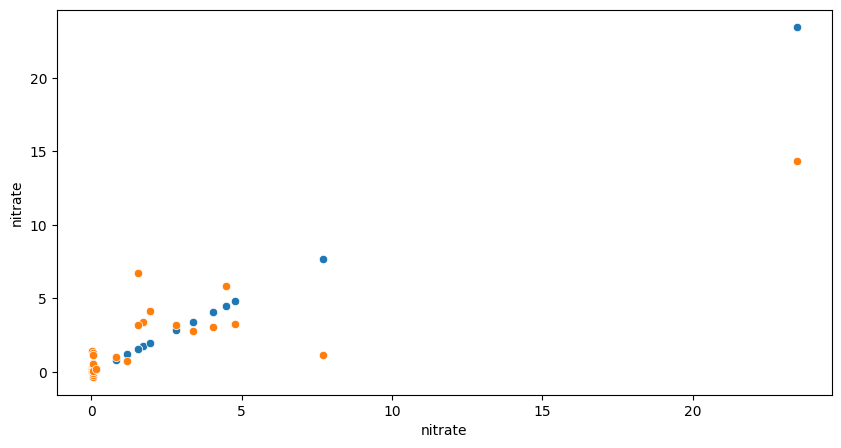

In [30]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

## Residuals

Text(0, 0.5, 'Residuals')

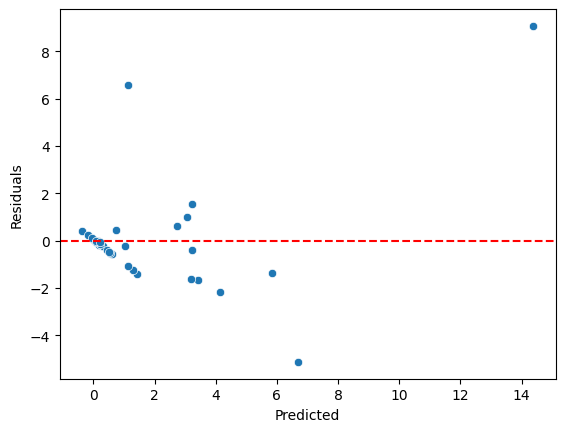

In [31]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [32]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

34
34
34
34


In [33]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

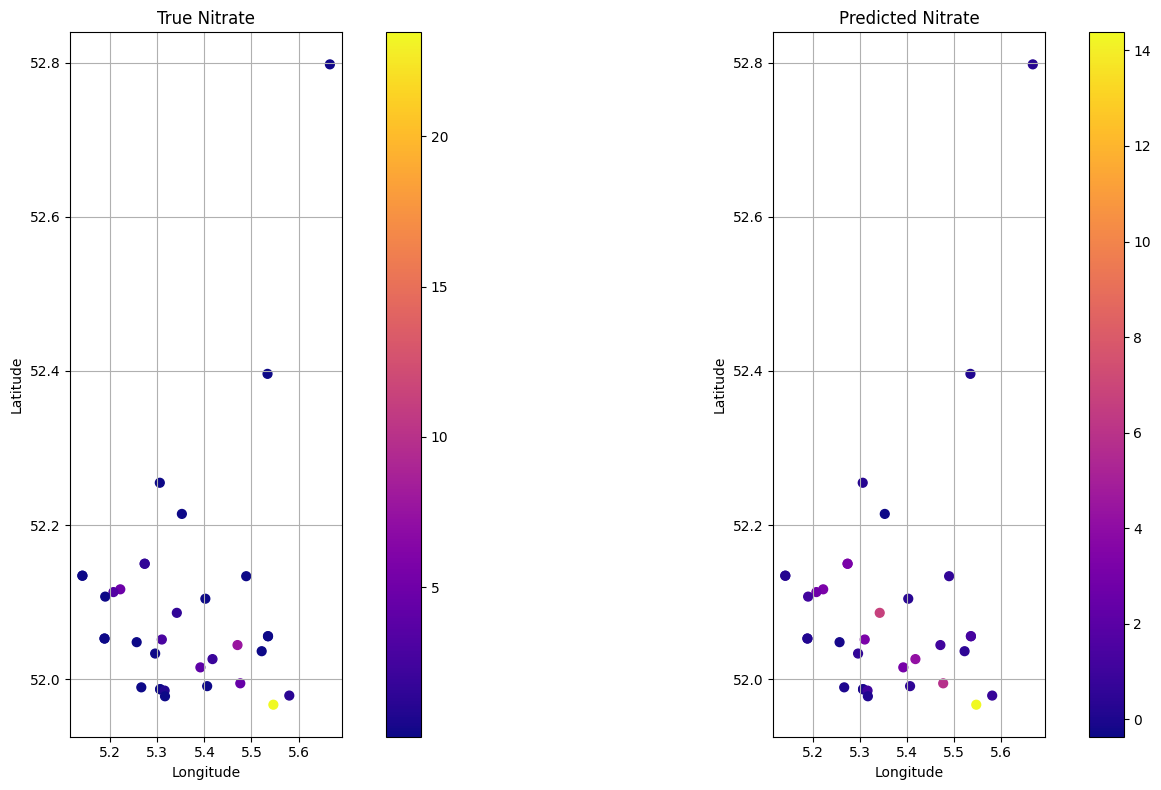

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

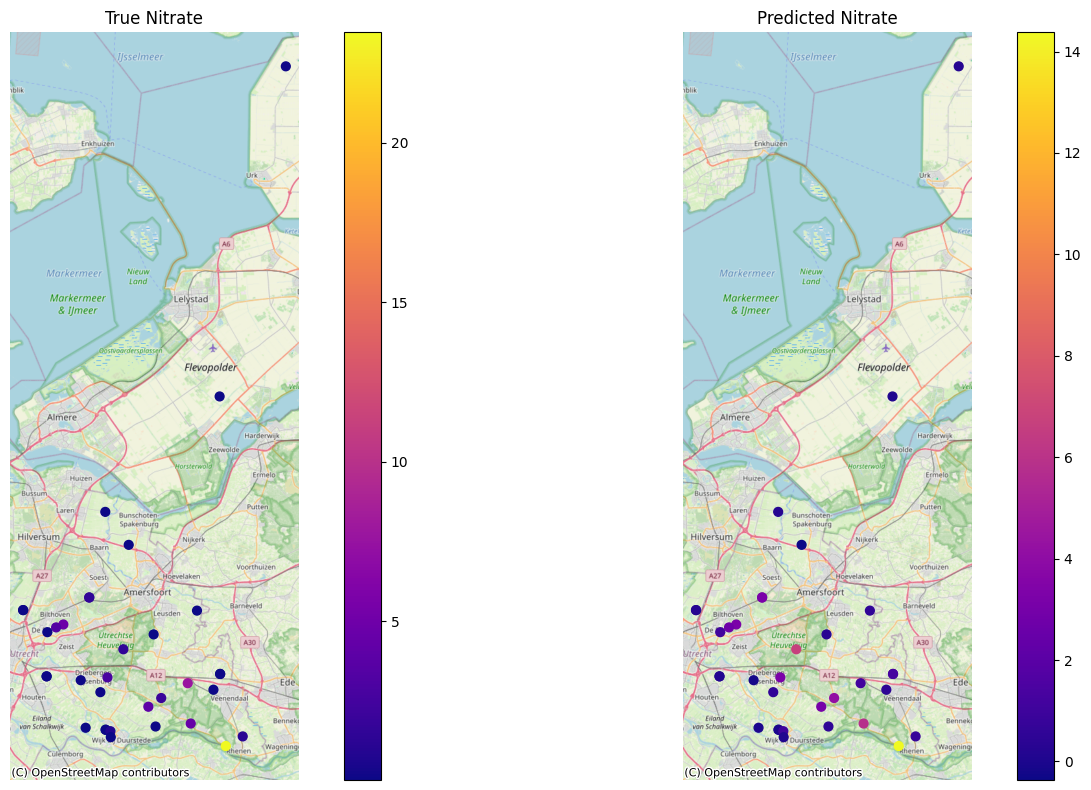

In [35]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()